# 네이버 영화 리뷰 감성 분류
- 데이터 다운로드 링크: https://github.com/e9t/nsmc/

## 1. 네이버 영화 리뷰 데이터에 대한 이해

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
import re
from konlpy.tag import Okt

In [12]:
train_data= pd.read_table('data/ratings_train.txt')
test_data= pd.read_table('data/ratings_test.txt')

In [13]:
# 영화 리뷰 개수
len(train_data), len(test_data)

(150000, 50000)

In [14]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [15]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


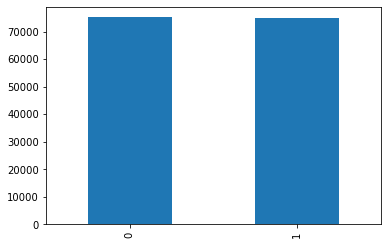

In [16]:
# 0 - 부정, 1 - 긍정
train_data['label'].value_counts().plot(kind='bar')

In [17]:
train_data['label'].value_counts()

0    75173
1    74827
Name: label, dtype: int64

In [18]:
# 리뷰 중에 Null 값을 가진 샘플이 있는지 확인
print(train_data.isnull().values.any())
print(test_data.isnull().values.any())

True
True


In [19]:
# 어떤 열에 존재하는지 확인
print(train_data.isnull().sum())

id          0
document    5
label       0
dtype: int64


In [20]:
print(test_data.isnull().sum())

id          0
document    3
label       0
dtype: int64


In [21]:
# Null 값을 가진 샘플이 어느 인덱스의 위치에 존재하는지 확인
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [22]:
# Null 값을 가진 샘플을 제거
train_data=train_data.dropna(how='any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [23]:
test_data=test_data.dropna(how='any') # Null 값이 존재하는 행 제거
print(test_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


## 2. 전처리

In [24]:
# 한글과 공백을 제외하고 모두 제거하는 정규 표현식
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [25]:
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0


### 훈련 데이터와 테스트 데이터에 대해 다음을 수행
- 토큰화와 불용어 제거
- 사이킷 런의 CountVectorizer가 처리할 수 있는 형태로 변환

In [27]:
from tqdm import tqdm_notebook
stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()

In [28]:
# 훈련 데이터
X_train=[]
for sentence in tqdm_notebook(train_data['document']):
    morphs = okt.morphs(sentence, stem=True) # 토큰화
    temp = ' '.join(morph for morph in morphs if not morph in stopwords)
    X_train.append(temp)

C:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
# 테스트 데이터
X_test=[]
for sentence in tqdm_notebook(test_data['document']):
    morphs = okt.morphs(sentence, stem=True) # 토큰화
    temp = ' '.join(morph for morph in morphs if not morph in stopwords)
    X_test.append(temp)

C:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
y_train=np.array(train_data['label'])
y_test=np.array(test_data['label'])

## 3. Naive Bayes 분류기로 분류하기

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB  # 다항분포 나이브 베이즈 모델
from sklearn.metrics import accuracy_score     # 정확도 계산

In [32]:
# DTM - Document Term Matrix
dtmvector = CountVectorizer()
X_train_dtm = dtmvector.fit_transform(X_train)
print(X_train_dtm.shape)

(149995, 42118)


In [33]:
# 사이킷 런에서 제공하는 나이브 베이즈 모델
model = MultinomialNB()
model.fit(X_train_dtm, y_train)

MultinomialNB()

In [34]:
# 테스트 데이터 DTM 형태로 변환
X_test_dtm = dtmvector.transform(X_test)
print(X_test_dtm.shape)

(49997, 42118)


In [35]:
predicted = model.predict(X_test_dtm) #테스트 데이터에 대한 예측
print("정확도: %.4f" % accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8248


### TF-IDF 적용

In [36]:
from sklearn.feature_extraction.text import TfidfTransformer

In [37]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(X_train_dtm)
tfidfv.shape

(149995, 42118)

In [38]:
model2 = MultinomialNB()
model2.fit(tfidfv, y_train)

MultinomialNB()

In [39]:
# DTM을 TF-IDF 행렬로 변환
tfidfv_test = tfidf_transformer.transform(X_test_dtm) 

In [40]:
predicted = model2.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도: %.4f" % accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8231
